# Stock market predictions - Decision Trees and Random Forests

Welcome to my rather scuffed implementation of the Decision Tree and Random Forest algorithms for stock market predictions.

The data used in this notebook is sourced from [this Kaggle dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs). Data from the GE stock ticker is used in specific, which can be found in the file "ge.us.txt" in CSV format. The dataset includes OHLC prices and the volume, all in 1-day intervals.

## Goals

The project's goal is to use the models above to predict the closing prices of a certain stock ticker. Namely, given the closing prices of a stock over n days, we want to predict the closing prices of the stocks over the next m days.

# Data preprocessing

## Importing modules

In [93]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor

## Pulling data

In [94]:
df = pd.read_csv("http://github.com/noeruchangd/MLProject/blob/master/data/ge.us.txt?raw=true")

df.drop('OpenInt', axis=1, inplace=True)

print(df)

             Date     Open     High      Low    Close     Volume
0      1962-01-02   0.6277   0.6362   0.6201   0.6201    2575579
1      1962-01-03   0.6201   0.6201   0.6122   0.6201    1764749
2      1962-01-04   0.6201   0.6201   0.6037   0.6122    2194010
3      1962-01-05   0.6122   0.6122   0.5798   0.5957    3255244
4      1962-01-08   0.5957   0.5957   0.5716   0.5957    3696430
...           ...      ...      ...      ...      ...        ...
14053  2017-11-06  20.5200  20.5300  20.0800  20.1300   60641787
14054  2017-11-07  20.1700  20.2500  20.1200  20.2100   41622851
14055  2017-11-08  20.2100  20.3200  20.0700  20.1200   39672190
14056  2017-11-09  20.0400  20.0710  19.8500  19.9900   50831779
14057  2017-11-10  19.9800  20.6800  19.9000  20.4900  100698474

[14058 rows x 6 columns]


In [108]:
def evaluate(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R2: {r2:.2f}")
    print(f"Test MAPE: {mape:.2f}")
def plot_prediction(y_pred, X_test):
    results = X_test.copy()
    results['Actual'] = y_test
    results['Predicted'] = y_pred
    results = results[['Actual', 'Predicted']]
    print(results.tail())

    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['Actual'], label='Actual', color='blue')
    plt.plot(results.index, results['Predicted'], label='Predicted', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Stock Closing Price')
    plt.title('Actual vs Predicted Closing Prices')
    plt.legend()
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

In [96]:
def compare_train_test(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)


    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"{model_name} Performance:")
    print(f"Training RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}, MAPE: {train_mape:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}, MAPE: {test_mape:.2f}")


# Preprocessing steps

In [97]:
df.describe()
df.set_index('Date', inplace=True)

print(df.dtypes)
# plt.figure(figsize = (10 , 5))
# sns.lineplot(df , x = df.index , y = 'Close')


Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


Text(0.5, 0, 'Date')

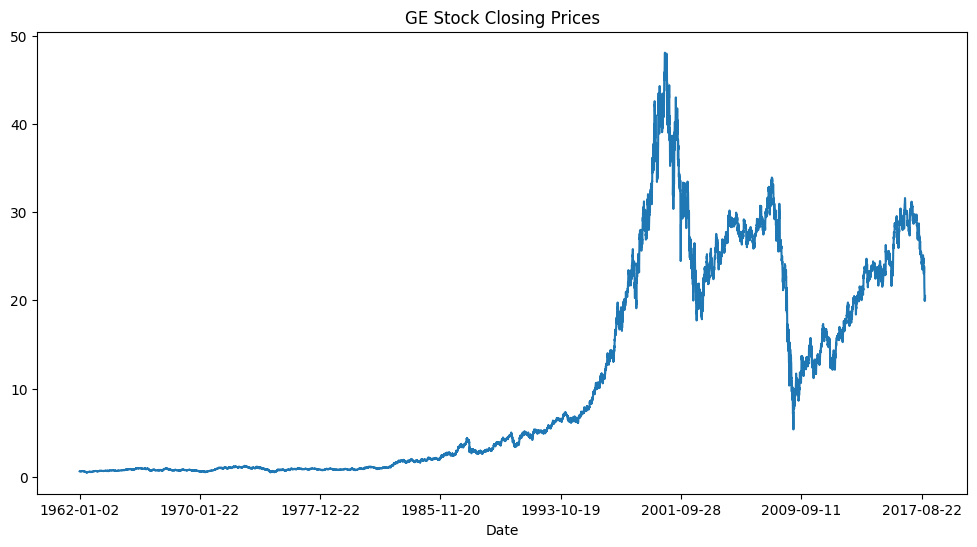

In [98]:
df['Close'].plot(title='GE Stock Closing Prices', figsize=(12, 6))
plt.xlabel('Date')



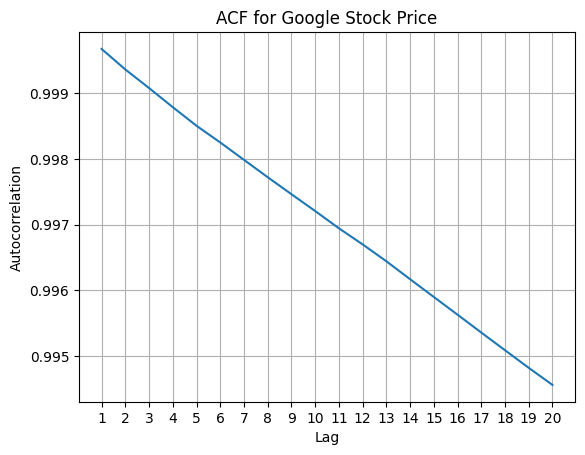

In [99]:
import statsmodels.api as sm # Shoutout to Chau for this!

# ACF for multiple lags
acf = sm.tsa.acf(df['Close'], nlags=20)

# Plot the ACF
plt.plot(range(1, 21), acf[1:])  # Start from lag=1
plt.title('ACF for Google Stock Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

Feature engineering

In [100]:
df['Mean_5'] = df['Close'].rolling(window=5).mean()
df['Mean_10'] = df['Close'].rolling(window=10).mean()
df['STD_5'] = df['Close'].rolling(window=5).std()
df['STD_10'] = df['Close'].rolling(window=10).std()
df['Close_t-1'] = df['Close'].shift(1)
df['Close_t-2'] = df['Close'].shift(2)
df['Close_t-3'] = df['Close'].shift(3)
df['Close_t-4'] = df['Close'].shift(4)
df['Close_t-5'] = df['Close'].shift(5)
df.describe()

,Open,High,Low,Close,Volume,Mean_5,Mean_10,STD_5,STD_10,Close_t-1,Close_t-2,Close_t-3,Close_t-4,Close_t-5
count,14058.000000,14058.000000,14058.000000,14058.000000,1.405800e+04,14054.000000,14049.000000,14054.000000,14049.000000,14057.000000,14056.000000,14055.000000,14054.000000,14053.000000
mean,10.534737,10.642538,10.421090,10.534161,2.423066e+07,10.534192,10.534254,0.143176,0.195168,10.533453,10.532780,10.532098,10.531409,10.530726
std,11.742897,11.868891,11.612159,11.743726,3.369859e+07,11.741743,11.740026,0.229171,0.297474,11.743844,11.743991,11.744130,11.744264,11.744403
min,0.459020,0.466900,0.451140,0.459020,0.000000e+00,0.467006,0.485478,0.000000,0.002498,0.459020,0.459020,0.459020,0.459020,0.459020
25%,0.901500,0.909600,0.893800,0.901500,5.496950e+06,0.904745,0.904090,0.010623,0.015253,0.901500,0.901500,0.901500,0.901500,0.901500
50%,3.880900,3.912700,3.824300,3.884800,1.597520e+07,3.860440,3.853200,0.039815,0.055791,3.880900,3.880900,3.880900,3.880900,3.880900
75%,21.416000,21.658000,21.149250,21.370000,2.853667e+07,21.339800,21.370600,0.189076,0.268566,21.370000,21.371000,21.372000,21.373000,21.374000
max,47.751000,48.459000,47.596000,48.056000,9.345354e+08,47.521400,47.240200,2.703550,3.492558,48.056000,48.056000,48.056000,48.056000,48.056000


In [103]:
prediction_days = 10
# df['Target'] = df['Close'].shift(-prediction_days)
# df.dropna(inplace=True)
#
# X = df.drop(columns=['Close'])
# y = df['Target']
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=False)

# Models

Decision tree (with only max_depth adjusted)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

# Create target columns for the next n days
for i in range(1, prediction_days + 1):
    df[f'Target_t+{i}'] = df['Close'].shift(-i)

# Drop rows with NaN values (due to shifting)
df.dropna(inplace=True)

# Update features and target
X = df.drop(columns=['Close'] + [f'Target_t+{i}' for i in range(1, prediction_days + 1)])
y = df[[f'Target_t+{i}' for i in range(1, prediction_days + 1)]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=False)

# Use MultiOutputRegressor with DecisionTreeRegressor
multi_output_tree = MultiOutputRegressor(RandomForestRegressor(max_depth=15, random_state=42))
multi_output_tree.fit(X_train, y_train)

y_pred = multi_output_tree.predict(X_test)

for i in range(prediction_days):
    print(f"Day {i+1} - RMSE: {np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])):.2f}")

predicted_df = pd.DataFrame(y_pred, index=y_test.index, columns=[f'Predicted_t+{i+1}' for i in range(prediction_days)])
actual_df = pd.DataFrame(y_test, index=y_test.index, columns=[f'Actual_t+{i+1}' for i in range(prediction_days)])

plt.figure(figsize=(12, 6))
for i in range(prediction_days):
    plt.plot(actual_df.index, actual_df.iloc[:, i], label=f'Actual_t+{i+1}', linestyle='dotted')
    plt.plot(predicted_df.index, predicted_df.iloc[:, i], label=f'Predicted_t+{i+1}')

plt.xlabel('Date')
plt.ylabel('Stock Closing Price')
plt.title('Actual vs Predicted Closing Prices for Next n Days')
plt.legend()
plt.show()

y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

# Calculate overall metrics
overall_rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
overall_r2 = r2_score(y_test_flat, y_pred_flat)
overall_mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat)

print(f"Overall RMSE: {overall_rmse:.2f}")
print(f"Overall R²: {overall_r2:.2f}")
print(f"Overall MAPE: {overall_mape:.2%}")

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
Best Accuracy: -27.18059995482655
Test RMSE: 0.06
Test R2: 1.00
Test MAPE: 0.00
            Actual  Predicted
Date                         
2017-06-15   20.13     20.063
2017-06-16   20.21     20.250
2017-06-19   20.12     20.063
2017-06-20   19.99     20.030
2017-06-21   20.49     20.451


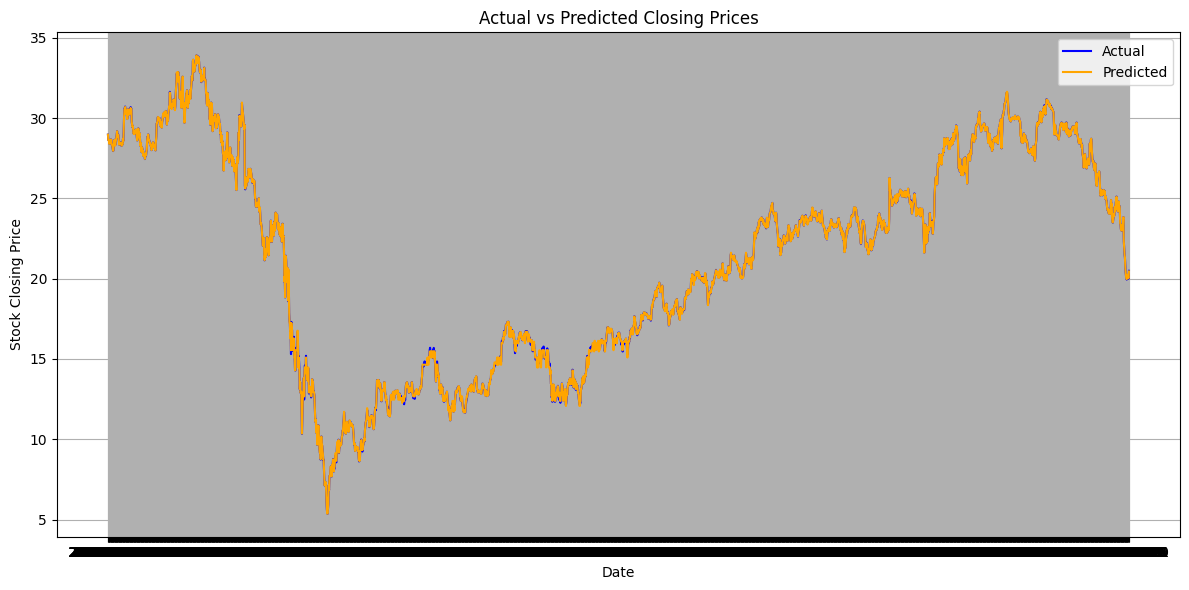

In [89]:
param_grid_DT = {
    'max_depth': [15],
    'min_samples_split': [3],
    'min_samples_leaf': [1],
    'max_features': [None],
    'criterion': ['squared_error']}

tree = GridSearchCV(estimator=DecisionTreeRegressor(),
                           param_grid=param_grid_DT,
                           cv=5,
                           scoring='neg_mean_squared_error')

tree.fit(X_train, y_train)

print("Best Hyperparameters:", tree.best_params_)
print("Best Accuracy:", tree.best_score_)

y_pred = tree.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

RF

Best Hyperparameters: {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best Accuracy: -52.18404671282316
Test RMSE: 0.06
Test R2: 1.00
Test MAPE: 0.00
            Actual  Predicted
Date                         
2009-11-25  15.258  15.238364
2009-11-27  15.354  15.607695
2009-11-30  15.540  15.542138
2009-12-01  15.056  14.816592
2009-12-02  15.258  15.169991


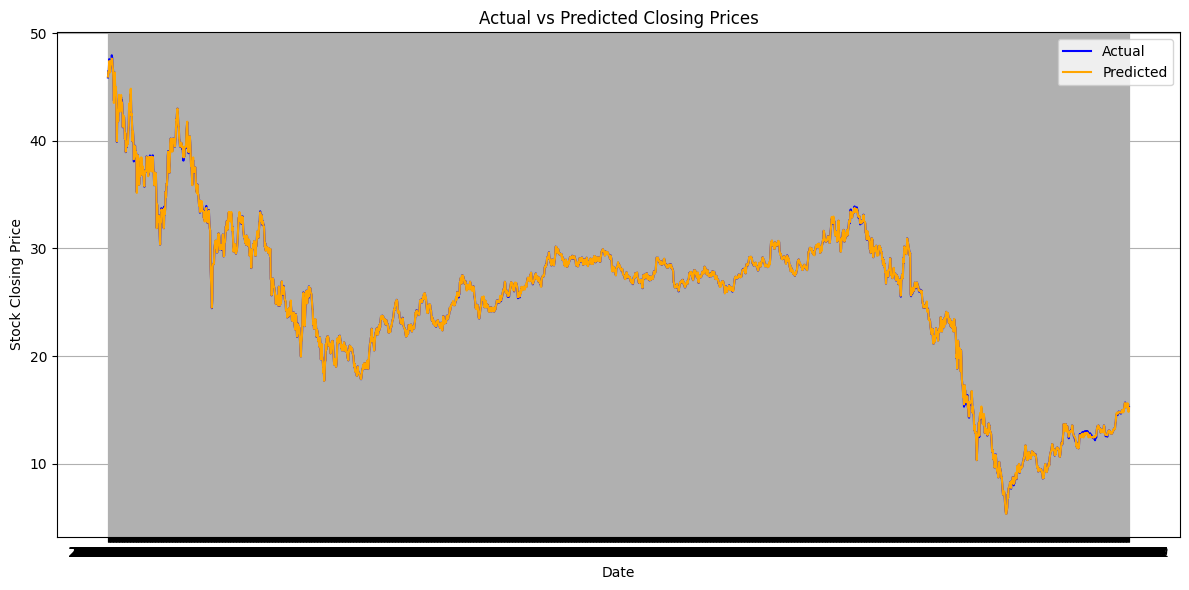

In [74]:
param_grid_RF ={
    'max_depth': [15],
    'n_estimators': [100],
    'min_samples_split': [3],
    'min_samples_leaf': [1],
    'max_features': [None],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}

forest = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid_RF,
                           cv=5,
                           scoring='neg_mean_squared_error')

forest.fit(X_train, y_train)
print("Best Hyperparameters:", forest.best_params_)
print("Best Accuracy:", forest.best_score_)

y_pred = forest.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

Test RMSE: 0.14
Test R2: 1.00
Test MAPE: 0.01
            Actual  Predicted
Date                         
2017-10-09   20.13  20.152638
2017-10-10   20.21  20.222278
2017-10-11   20.12  20.128265
2017-10-12   19.99  19.965155
2017-10-13   20.49  20.285031


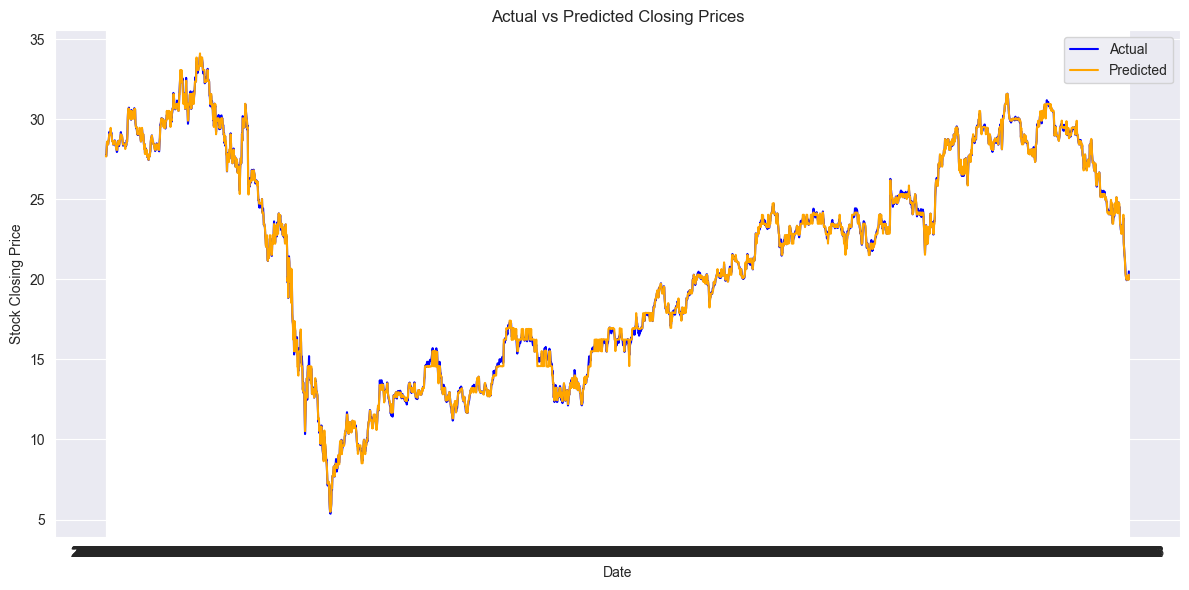

In [165]:
param_grid_GBR = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}
grad = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid_RF,
                           cv=5,
                           scoring='neg_mean_squared_error')
grad.fit(X_train, y_train)
print("Best Hyperparameters:", grad.best_params_)
print("Best Accuracy:", grad.best_score_)

y_pred = grad.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

Test RMSE: 0.33
Test R2: 1.00
Test MAPE: 0.01
            Actual  Predicted
Date                         
2017-10-09   20.13  19.943789
2017-10-10   20.21  20.508665
2017-10-11   20.12  19.894245
2017-10-12   19.99  19.910463
2017-10-13   20.49  20.496082


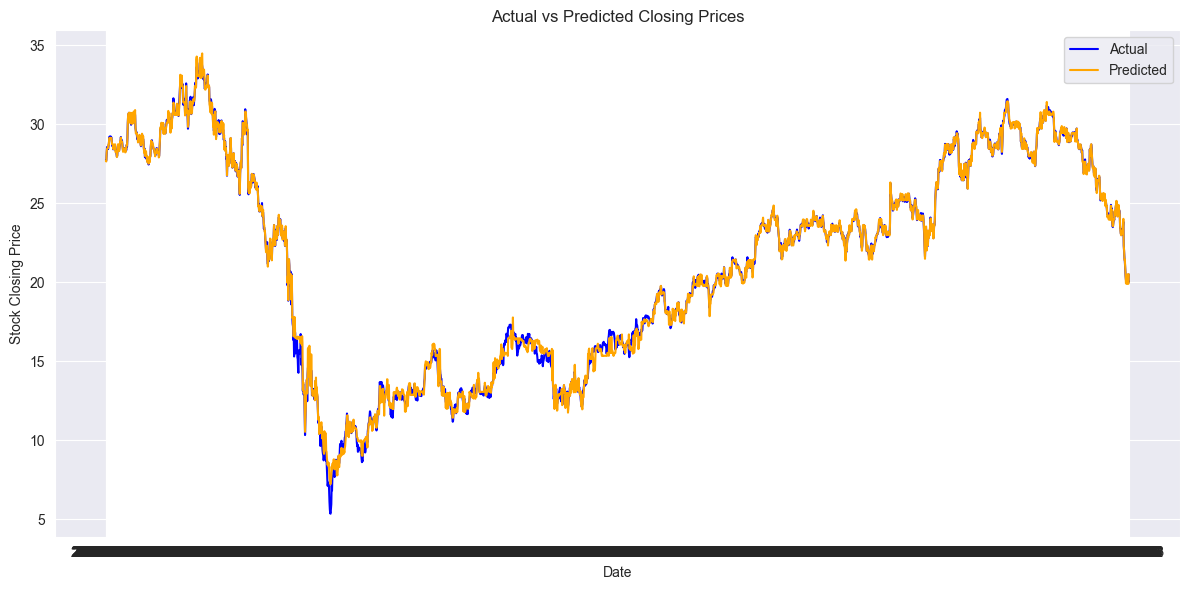

In [166]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

predict(xgb, X_test)

Overfitting test

In [64]:
compare_train_test(tree, X_train, X_test, y_train, y_test, "Decision Tree")
compare_train_test(forest, X_train, X_test, y_train, y_test, "Random Forest")

Decision Tree Performance:
Training RMSE: 0.00, R2: 1.00, MAPE: 0.00
Test RMSE: 0.11, R2: 1.00, MAPE: 0.00
Random Forest Performance:
Training RMSE: 0.01, R2: 1.00, MAPE: 0.00
Test RMSE: 0.05, R2: 1.00, MAPE: 0.00


From this, it can be reasonably concluded that the Decision Tree and XGBoost model is overfitting, but not the Random Forest.